# Correlation with clinical outcome - AMLSG

The evaluation of the merged Palma-Ikonomi models focuses on their ability to predict clinical outcomes for patients with specific mutations. Palma et al. has connected their network to three cancer hallmark phenotypes: apoptosis, differentiation and proliferation. In addition, an integrated network score was defined as subtracting the value of apoptosis and differentiation from the value of the proliferation to reflect the malignancy of the cancer. The phenotype scores were then used as a proxy of the prediction power of the model to patients’ clinical outcomes.

In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

In [3]:
home = "persistent/" # home path for Logic Model Merger
model1 = biolqm.load(home + "LogicModelMerger/Models/" + model1name + ".sbml")
model2 = biolqm.load(home + "LogicModelMerger/Models/" + model2name + ".sbml")
merged_and = biolqm.load(home + "LogicModelMerger/Models/merged_and_" + model1name + "_" + model2name + ".sbml")
merged_inhibitor_wins = biolqm.load(home + "LogicModelMerger/Models/merged_inhibitor_wins_" + model1name + "_" + model2name + ".sbml")
merged_or = biolqm.load(home + "LogicModelMerger/Models/merged_or_" + model1name + "_" + model2name + ".sbml")

The evaluation of clinical outcomes prediction using the AMLSG dataset is similar to the approaches that Palma et al. used in their publication.  

## Simulations of the models

As described in the paper:  
>In silico simulations were performed for different genomic profiles, including loss of function of NPM1 and/or DNMT3A and/or gain of function of FLT3. In our Boolean model simulation, oncogenes and TSG were set to fixed values of 1 and 0, respectively. Each node of the network is associated to a Boolean expression, describing how the value of the node changes depending on the activities of the upstream regulatory nodes. Nonmutated genes were considered active or inactive depending on the activities of the upstream regulatory nodes. This approach enabled to generate eight “mutation-specific” models. To estimate the level of activation of each phenotype, we assumed that the activities of the nodes directly linked to a phenotype have an additive effect on the value of the phenotype. Hence, we estimated phenotype activation by adding up the contribution of the upstream activators and subtracting that of the upstream inhibitors. Thus, a phenotype is considered “most active” whenever all activator nodes are on and inhibitors off at a steady state.  
  
Following a similar approach, we first set the fix values of the models according to the 8 mutation profiles (mutation status of FLT3, NPM1 and DNMT3A). And then run simulations using the `biolqm.fixpoints` function from `BoolNet` to compute the complete list of logical stable states (or fixpoints) of the model.   

Using the stable states, the phenotype scores can be calculated as:
- Apoptosis = tp53 - bcl2
- Differentiation =	cebpa + etv6 - meis1
- Proliferation	= myc + ccnd1 + sox4 + meis1 + stat5a
- Network = Proliferation - Differentiation - Apoptosis 

In [ ]:
# Simulate the models for each mutation profile and return the phenotype scores
def simulation(model):

    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['MYC'] + results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results

## Correlation with hazard ratio for death

As described by Palma et al.:
>We next evaluated whether we could use these models to infer some clinical outcomes of patients carrying mutations in NPM1 and/or DNMT3A and/or FLT3. To this end we made use of the clinical information provided by Papaemmanuil et al. reporting the impact of somatic mutations on overall survival and we compared the mutation-specific hazard ratios with the predictions of our models. As a proxy for the predictive power of our model, we defined the “integrated network phenotype” score, which is calculated by subtracting from the activation value of the phenotype “proliferation” the values of “apoptosis” and “differentiation”.  
  
Similarly, we correlate the derived network scores with the hazard ratio of death taken from the Papaemmanuil et al. publication.  

### Data
The hazard ratio of death was given by a clinical study of 1540 AML patients (AMLSG), where survival analysis was performed using Cox proportional-hazards methods. Mutation-specific hazards for FLT3, NPM1, DNMT3A and their combinations are given in Table 2 in the publication.
>Papaemmanuil E, Gerstung M, Bullinger L, Gaidzik VI, Paschka P, Roberts ND, et al. Genomic Classification and Prognosis in Acute Myeloid Leukemia. N Engl J Med. 2016 Jun 9;374(23):2209–21.

In [4]:
# Calculate the pearson correlation between the phenotype score and hazard ratio
def hazard_ratio_pc(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio,simulation_results])
    
    phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
    hazard_ratio_pc_results = pd.DataFrame()
    
    for phenotype in phenotypes:
        # Extract hazard ratio and phenotype values
        x = results.loc['Hazard_ratio', :]
        y = results.loc[phenotype, :]
        
        # Calculate Pearson Correlation and p-value
        hazard_ratio_pc_results.loc[phenotype, 'pc'], hazard_ratio_pc_results.loc[phenotype, 'p_value'] = pearsonr(x, y)
    return hazard_ratio_pc_results
    
# Draw the correlation plot for all four phenotype scores
def hazard_ratio_plot(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio, simulation_results])
    
    # Plotting scatterplots
    phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for i, phenotype in enumerate(phenotypes):
        ax = axes[i // 2, i % 2]
        # Extract hazard ratio and phenotype values
        y = results.loc['Hazard_ratio', :]
        x = results.loc[phenotype, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{phenotype} vs Hazard Ratio for Death')
        ax.set_ylabel('Hazard Ratio')
        ax.set_xlabel(phenotype)
    
        # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
        
        # Annotate Pearson Correlation and p-value
        if phenotype in ['APOPTOSIS', 'DIFFERENTIATION']:
            ax.text(0.05, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                    transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
        else:
            ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                    transform=ax.transAxes, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

# Draw the correlation plot for the network score only
def hazard_ratio_plot_network(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio, simulation_results])
    
    # Plotting scatterplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Extract hazard ratio and phenotype values
    y = results.loc['Hazard_ratio', :]
    x = results.loc['NETWORK', :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title('Hazard Ratio for Death vs Network score')
    ax.set_ylabel('Hazard Ratio for Death')
    ax.set_xlabel('Network score')

    # Annotate each data point
    for j in range(len(x)):
        label = x.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

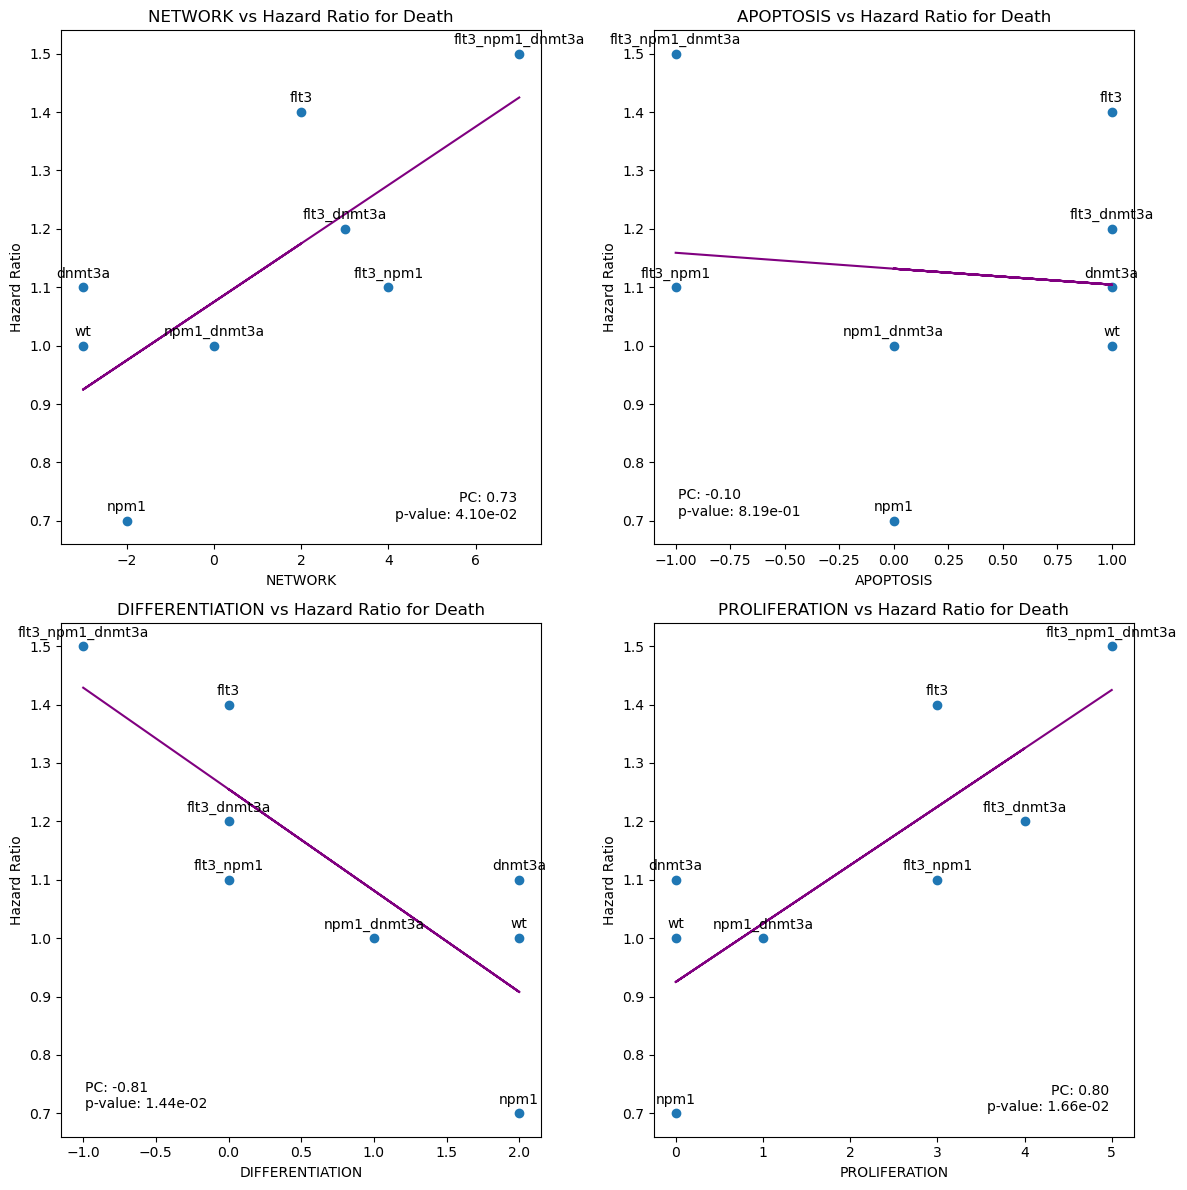

In [5]:
# Palma 2021's results
simulation_results_palma = simulation(Palma)
hazard_ratio_pc_palma = hazard_ratio_pc(simulation_results_palma, home + "Data/AMLSG/Hazard Ratio for Death.csv")
hazard_ratio_plot(simulation_results_palma, home + "Data/AMLSG/Hazard Ratio for Death.csv")

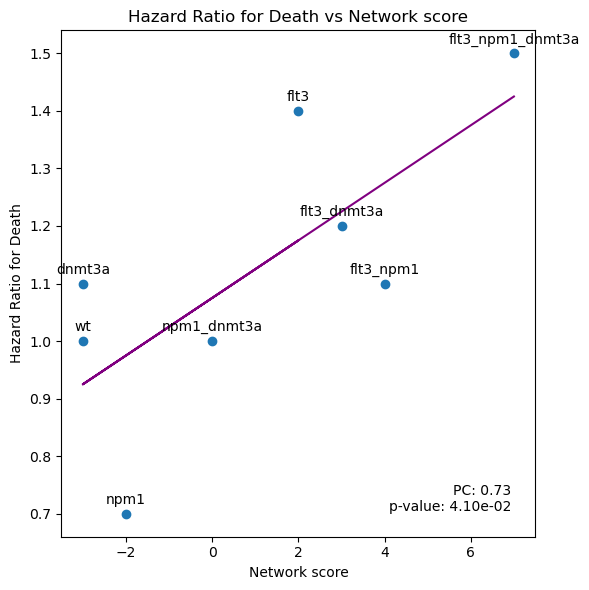

In [6]:
# plot only the network scores for the manuscript figure
hazard_ratio_plot_network(simulation_results_palma, home + "Data/AMLSG/Hazard Ratio for Death.csv")

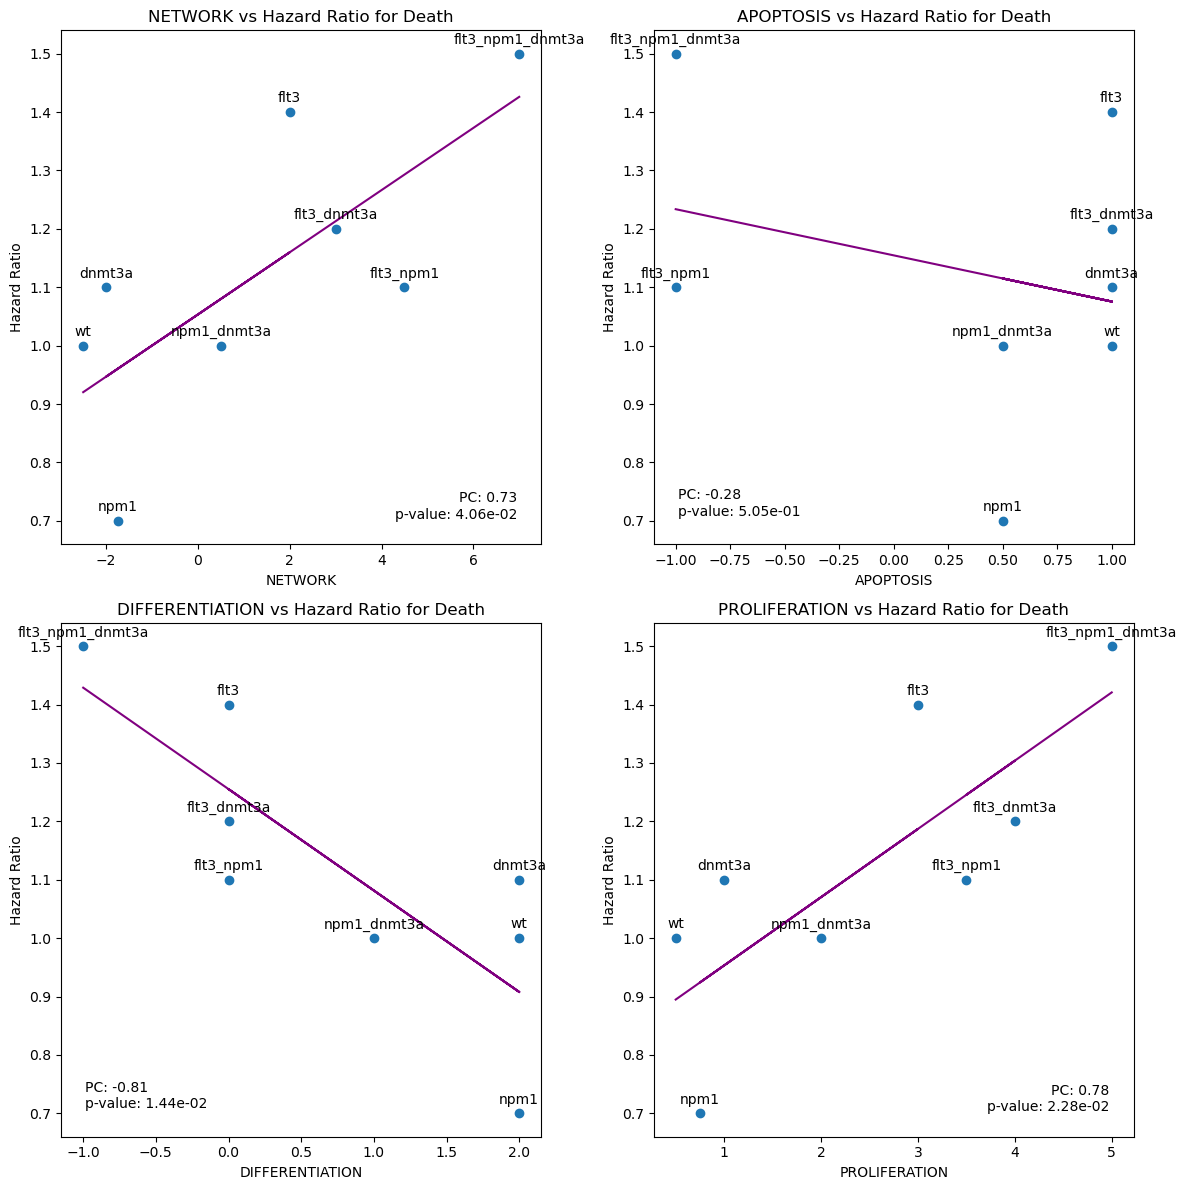

In [7]:
# Merged rules using 'OR'
simulation_results_or = simulation(merged_or)
hazard_ratio_pc_or = hazard_ratio_pc(simulation_results_or, home + "Data/AMLSG/Hazard Ratio for Death.csv")
hazard_ratio_plot(simulation_results_or, home + "Data/AMLSG/Hazard Ratio for Death.csv")

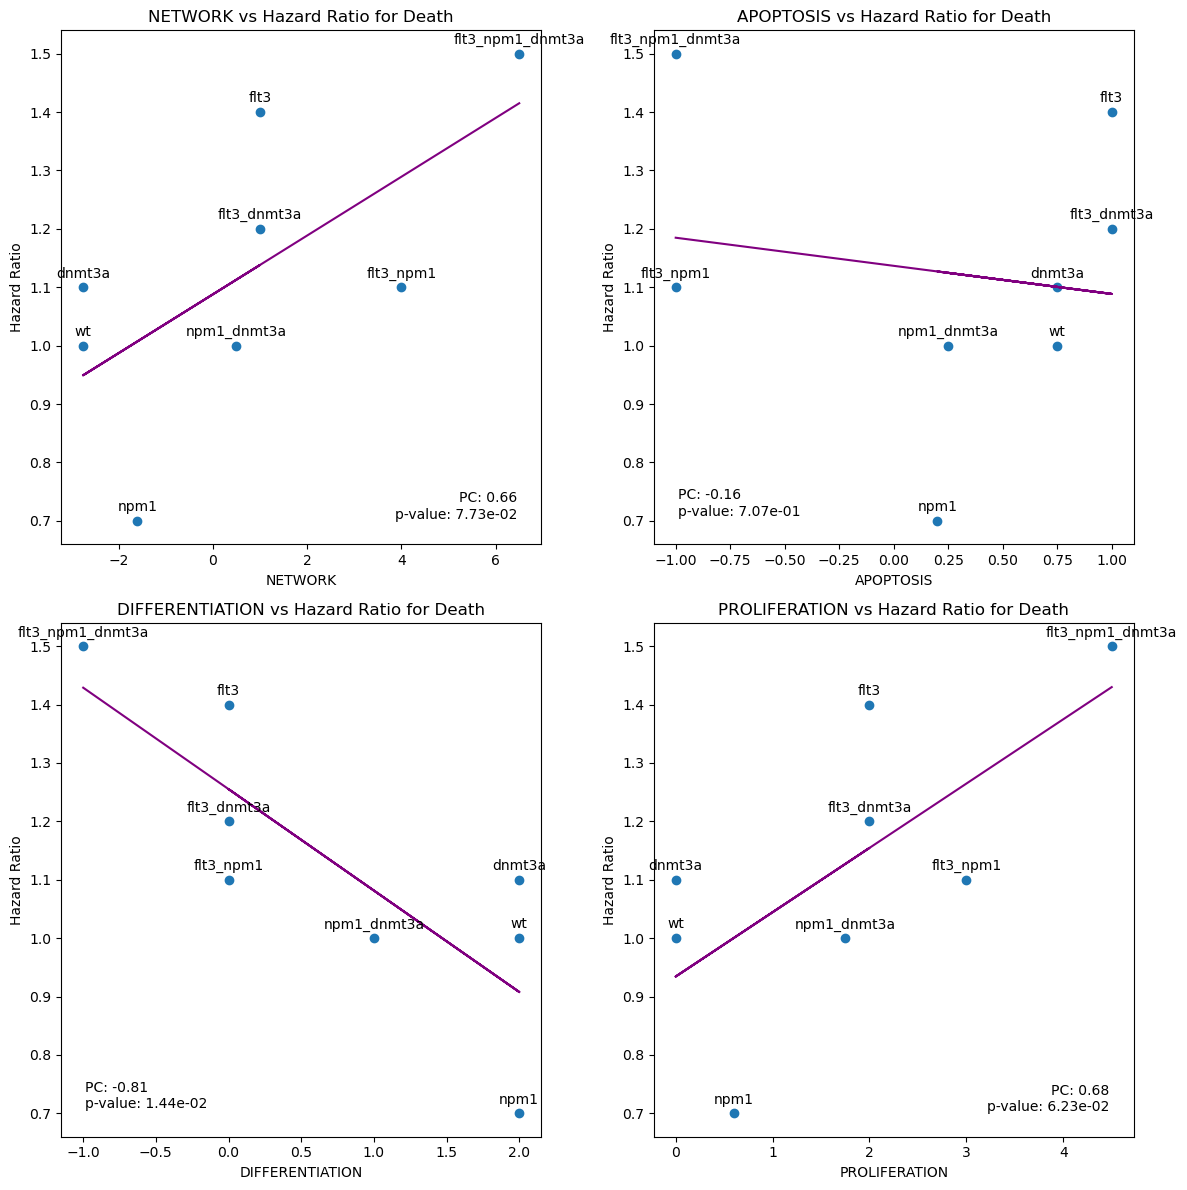

In [8]:
# Merged rules using 'Inhibitor wins'
simulation_results_inhibitor_wins = simulation(merged_inhibitor_wins)
hazard_ratio_pc_inhibitor_wins = hazard_ratio_pc(simulation_results_inhibitor_wins, home + "Data/AMLSG/Hazard Ratio for Death.csv")
hazard_ratio_plot(simulation_results_inhibitor_wins, home + "Data/AMLSG/Hazard Ratio for Death.csv")

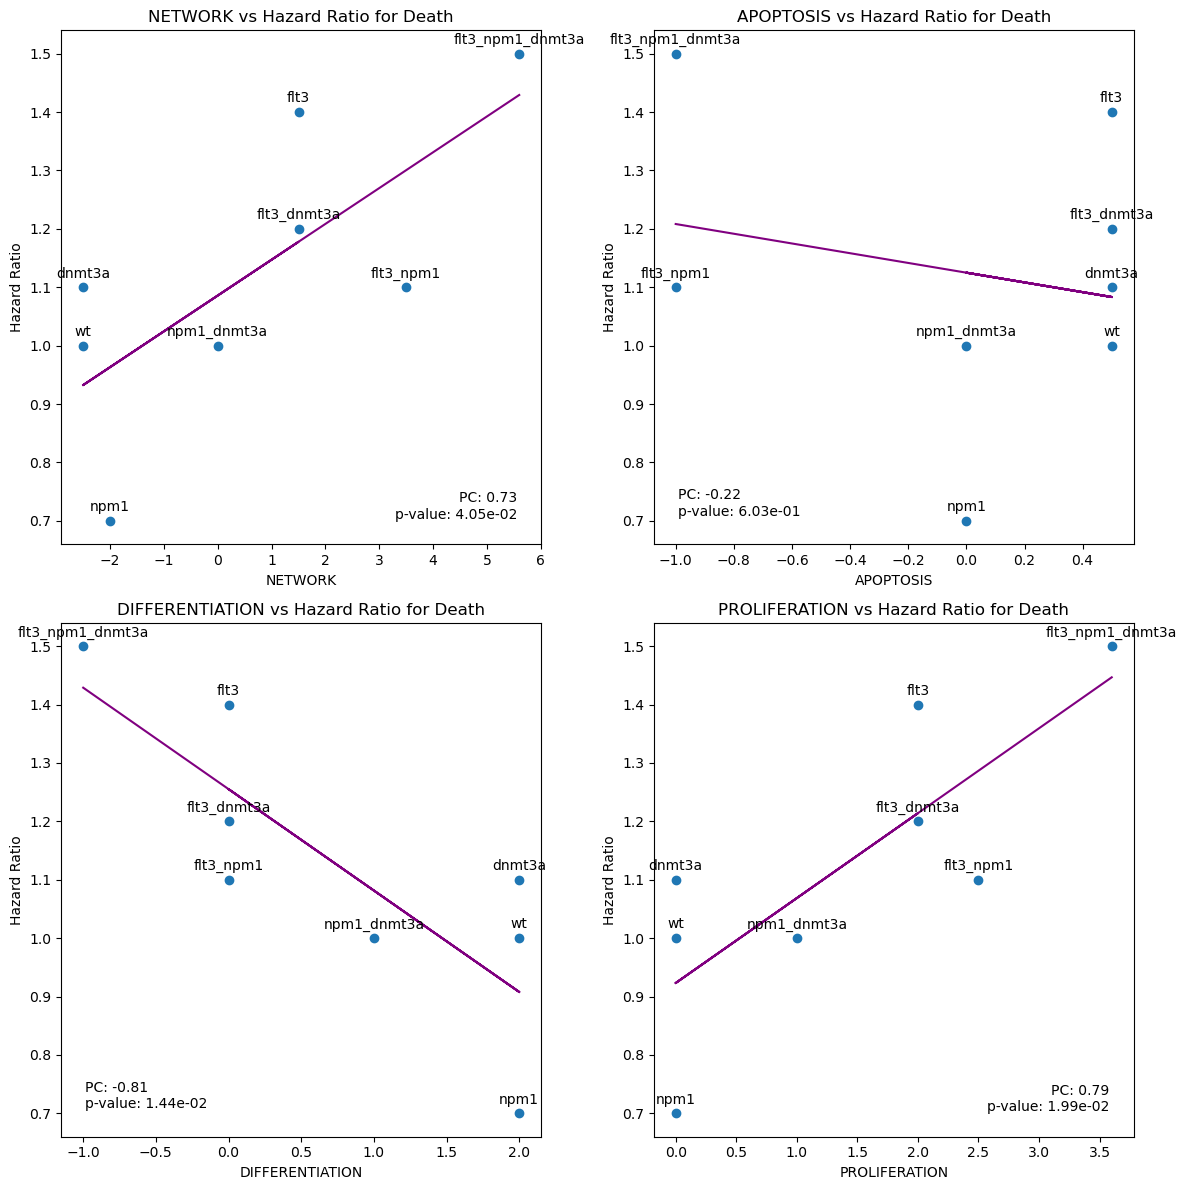

In [9]:
# Merged rules using 'AND'
simulation_results_and = simulation(merged_and)
hazard_ratio_pc_and = hazard_ratio_pc(simulation_results_and, home + "Data/AMLSG/Hazard Ratio for Death.csv")
hazard_ratio_plot(simulation_results_and, home + "Data/AMLSG/Hazard Ratio for Death.csv")

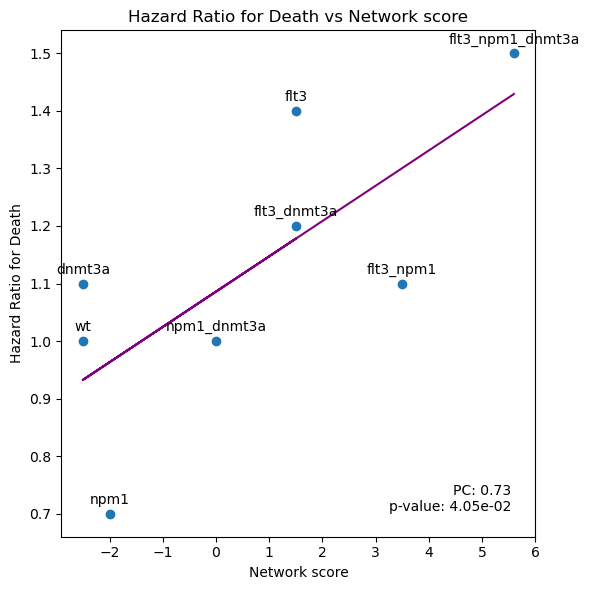

In [10]:
# plot only the network scores for the manuscript figure
hazard_ratio_plot_network(simulation_results_and, home + "Data/AMLSG/Hazard Ratio for Death.csv")

In [11]:
# Display the results side by side
from IPython.display import display_html
def display_side_by_side(dfs: list, titles: list):
    """Display dataframes side by side with titles"""
    html_str = ''
    for df, title in zip(dfs, titles):
        df_html = df.to_html()
        df_html = df_html.replace('<table border="1" class="dataframe">', 
                                  f'<table border="1" class="dataframe" style="display:inline;margin-right:20px;"><caption style="text-align:center;font-weight:bold">{title}</caption>')
        html_str += df_html
    display_html(html_str, raw=True)

titles = ['Palma', 'OR', 'Inhibitor Wins', 'AND']
display_side_by_side([hazard_ratio_pc_palma, hazard_ratio_pc_or, hazard_ratio_pc_inhibitor_wins, hazard_ratio_pc_and], titles=titles)


,pc,p_value
NETWORK,0.727142,0.040961
APOPTOSIS,-0.096976,0.819306
DIFFERENTIATION,-0.811666,0.014430
PROLIFERATION,0.802296,0.016568
,pc,p_value
NETWORK,0.728021,0.040596
APOPTOSIS,-0.277943,0.505075
DIFFERENTIATION,-0.811666,0.014430
PROLIFERATION,0.778594,0.022827
,pc,p_value


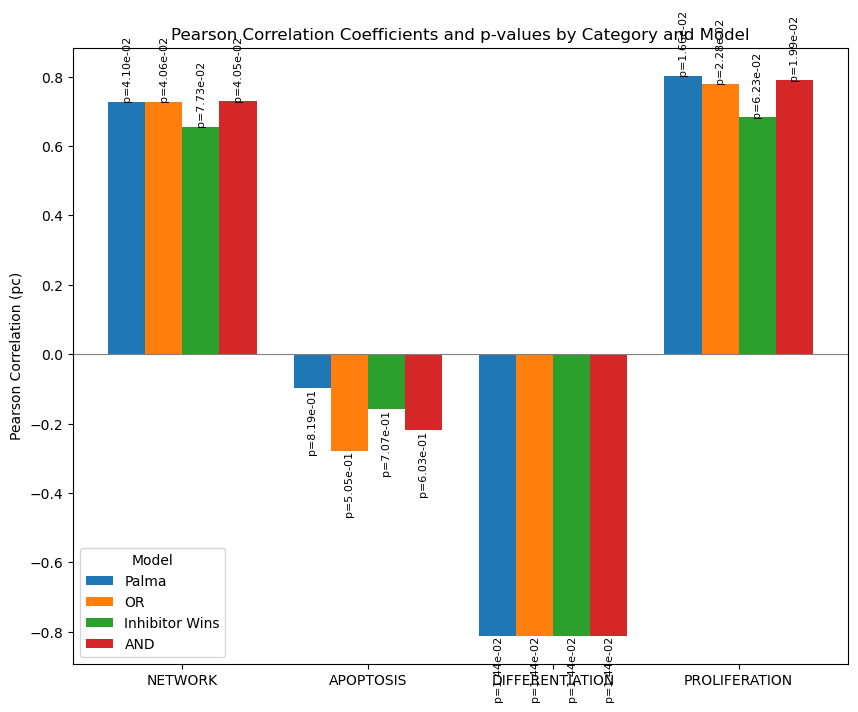

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = hazard_ratio_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

def plot_df(df, ax, position, label):
    bars = ax.bar(x + position * width, df['pc'], width, label=label)
    # Annotate p-value on each bar
    for bar, p_value in zip(bars, df['p_value']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'p={p_value:.2e}', 
                ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=8, rotation=90)

# Plot each dataframe
plot_df(hazard_ratio_pc_palma, ax, -1.5, 'Palma')
plot_df(hazard_ratio_pc_or, ax, -0.5, 'OR')
plot_df(hazard_ratio_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(hazard_ratio_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values by Category and Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

## Conclusion
**The phenotype scores of the merged models correlate well with the hazard ratio, with more significant p-values compared with the results from the Palma model except for the inhibitor wins model.**   